In [1]:
import numpy as np
import pandas as pd
import logging
import os
from scipy import interpolate

In [2]:
def preProcess(cwd):
    fileNames = os.listdir(cwd)
    clearedData = pd.ExcelWriter('clearedData.xlsx')
    for f in fileNames:
        if f.startswith('~$'):
            continue
        print(f)
        if os.path.splitext(f)[1] == '.xlsx':
            ff = os.path.join('data', f)
            df = pd.read_excel(ff, 'Sheet1')
            time = df.loc[:,'TIME'].values[1:]
            time1 = df.loc[:, 'TIME.1'].values[1:]
            
            time = np.array(time)[~np.isnan(time)]
            time1 = np.array(time1)[~np.isnan(time1)]
            
            (timeEps, timeLP) = (time, time1) if len(time) < len(time1) else (time1, time)
            eps = df.loc[:, 'EPS'].values[1:]
            eps = np.array(eps)[~np.isnan(eps)]
            
            #timeLP = np.array(timeLP)[np.where(timeLP < np.max(timeEps))]
            #wprint(timeLP)
            timeLP = timeLP[timeLP < np.max(timeEps)]
            
            funcInterp = interpolate.interp1d(timeEps, eps, bounds_error=None)
            try:
                epsFullLength = funcInterp(timeLP).reshape(-1,1)
            except(ValueError):
                print(timeLP, timeEps)
            
            timeLP = timeLP.reshape(-1,1)
            LP = df.loc[:,'LP'].values[1:]
            LP = LP[0:len(timeLP)].reshape(-1,1)
            
            TRI = df.loc[:,'TRI'].values[1:]
            TRI = TRI[0:len(timeLP)].reshape(-1, 1)

            data = np.hstack([timeLP, epsFullLength, LP, TRI])
            dff = pd.DataFrame(data, columns=['TIME', 'EPS', 'LP', 'TRI'])
            dff.to_excel(clearedData, sheet_name=os.path.splitext(f)[0])
    clearedData.save()

In [113]:
preProcess('/Users/aaron/Documents/GitHub/pyMaterialTestsProcess/ExperimentProcess/GISSIMO/data')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/aaron/Documents/GitHub/pyMaterialTestsProcess/ExperimentProcess/GISSIMO/data'

In [114]:
def readXlsx(fileName):
    """
    read all sheets in xls file
    input:
        fileName
    output:
        listEta, listThetaBar, listEpsilon in sheets
    """
    xlsx = pd.ExcelFile(fileName)
    etaThetaEpsilon = []
    for sheet in xlsx.sheet_names:
        #print(sheet)
        df = pd.read_excel(xlsx, sheet)
        eta = df.loc[:, 'TRI'].values.reshape(-1, 1)
        thetaBar = df.loc[:, 'LP'].values.reshape(-1, 1)
        eplison = df.loc[:, 'EPS'].values.reshape(-1, 1)
        ind = np.where(eplison>0)
        #print(sheet)
        #print(ind)
        ete = np.hstack([eta, thetaBar, eplison])
        
        etaThetaEpsilon.append(ete[ind[0],:])
    
    #logging.debug(etaThetaEpsilon)
    etaThetaEpsilon = np.array(etaThetaEpsilon)
    return etaThetaEpsilon

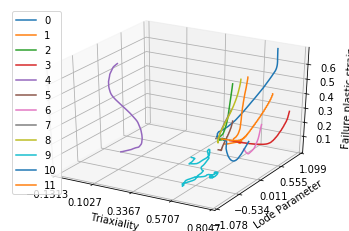

In [132]:
tests = readXlsx('clearedData.xlsx')

import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure()

ax = fig.gca(projection='3d')
plots = []
labels = []
ii = 0
for test in tests:
    xx, yy, zz = test[:, 0], test[:, 1], test[:, 2]
    pl = ax.plot(xx, yy, zz, label=str(ii))#, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    plots.append(pl)
    labels.append(str(ii))
    ii = ii + 1
    
ax.legend()#
ax.xaxis.set_major_locator(LinearLocator(5))
ax.yaxis.set_major_locator(LinearLocator(5))
ax.set_xlabel('Triaxiality')
ax.set_ylabel('Lode Parameter')
ax.set_zlabel('Failure plastic strain')

plt.show()

In [133]:
from scipy import integrate
import warnings
warnings.filterwarnings("error")

def simplifiedMMC(eta, thetaBar, param):
    """
    simplified MMC model 
    sigma = A * eps_p^n
    output:
        epsilonPlasticFailure: failure strain
    """
    A, n, c1, c2 = param
    try:
        
    #print(param)
        comp1 = np.sqrt((1+np.power(c1, 2)) / 3) * np.cos(thetaBar * np.pi / 6)
    #print(comp1.shape)
        comp2 = c1 * (eta + 1 / 3 * np.sin(thetaBar * np.pi / 6))
    #print(A / c2 * (comp1 + comp2), -1/n)
        comp = comp1 + comp2
    #comp = comp[np.where(comp>0)]
        epsilonPlasticFailure = np.power(A / c2 * comp, -1/n)
    #print(epsilonPlasticFailure.shape)
    #print(np.any(np.isnan(epsilonPlasticFailure)))
    except(RuntimeWarning):
        print('run time warning',A, n, c1, c2)
        epsilonPlasticFailure = np.zeros(comp.shape)
    
    return epsilonPlasticFailure

def accumulatedDamage(model, eta, thetaBar, epsilon, param):
    """
    Accumulating Damage Model
    input:
        model: Damage mode
        eta: eta list
        thetaBar: theraBar list
        epsilon: epsilon List
        param: A, n, c1, c2
    output:
        damage Indicator
    """
    #'epsilonMMC = np.zeros(eta.shape)'
    #'for ii, (eta, thetaBar) in  enumerate(zip(eta, thetaBar)):'
    epsilonPlasticFailure = model(eta, thetaBar, param)
    #'epsilonMMC[ii] = epsilonPlaticFailure'
   
    damageIndicator = integrate.trapz(1/ epsilonPlasticFailure, epsilon)
                      #np.sum(epsilon / epsilonPlasticFailure)
                      #integrate.tr (1 / epsilonPlaticFailure, epsilon)

    #print(epsilonPlasticFailure)
    return damageIndicator

def MMCSurface(*param):
    eta = np.arange(0, 1.1, 0.1)
    theta = np.arange(-1, 1.1, 0.1)
    etaX, thetaY = np.meshgrid(eta, theta, sparse=False)
    #z = np.sin(xx**2 + yy**2) / (xx**2 + yy**2)
    #h = plt.contourf(x,y,z)
    epsilon = simplifiedMMC(etaX, thetaY, param)
    return etaX, thetaY, epsilon

In [134]:
from scipy import optimize


def testResultsAcc(param, tests):
    """
    tests result to damgaIndicator
    """
    indicators = np.zeros([tests.shape[0]])
    for ii, test in enumerate(tests):
        eta = test[:, 0]
        theta = test[:, 1]
        epsilon = test[:, 2]
        damageIndicator = accumulatedDamage(simplifiedMMC, eta, theta, epsilon, param)
        #print(damageIndicator)
        indicators[ii] = damageIndicator
    return indicators

def testResulsUsingFractureStrain(param, tests):
    epsMMC = np.array([simplifiedMMC(test[-1,0], test[-1, 1], param) for test in tests]).reshape(-1,1)
    #epsTest = tests[:, -1, 2].reshape(-1,1)
    return epsMMC 

def errAcc(param, x, y):
    A, n, c1, c2 = param
    #print(Paramters.A, Paramters.n)
    return testResultsAcc((A,n, c1, c2), x) - y

def errFractureStrain(param, x, y):
    epsMMC = testResulsUsingFractureStrain(param, x)
    epsTest = np.array([test[-1, 2] for test in x]).reshape(-1,1)
    #print((epsMMC-epsTest).T)
    #print(epsMMC-epsTest.T[0])
    return (epsMMC - epsTest).T[0] 
    #return np.sum((epsMMC - epsTest).T[0] ** 2)

def fitModelUsingFractureStrain(tests):
    targets = np.ones([tests.shape[0]])
    #result = testResults(tests,(996.68, 0.026, 0.1, 500))
    #res = optimize.differential_evolution(errFractureStrain,bounds=([0,5000],[0,100],[0, 100],[0, 10000]), args=(tests, targets))
    #res0 = (2000, 0.1, .1, 6000)
    res = optimize.least_squares(errFractureStrain, x0=(2000, 0.1, .1, 6000), bounds=([0,0,0,0],[10000, 100,1000,10000]), args=(tests, targets))
    #print(err(res[0], tests, targets))
    #indicators = testResults(tests, (96.68, 0.02772, res[0][0], res[0][1]))
    #Aprint(func((996.68, 0.02772,res[0][0], res[0][1]), tests))
    return res

def fitDamageAcc(tests, res0):
    targets = np.ones([tests.shape[0]])
    #result = testResults(tests,(996.68, 0.026, 0.1, 500))
    res = optimize.least_squares(errAcc, res0, bounds=([0,0,0,0],[10000, 100,1000,10000]), args=(tests, targets))
    
    #print(err(res[0], tests, targets))
    #indicators = testResults(tests, (96.68, 0.02772, res[0][0], res[0][1]))
    #Aprint(func((996.68, 0.02772,res[0][0], res[0][1]), tests))
    return res


In [135]:
print(tests.shape)
tests = tests#[(0,1,2,3,4,5,6,7,8,10,11,12),]
resUsingFractureStrain = fitModelUsingFractureStrain(tests)
resUsingFractureStrain.x, resUsingFractureStrain.fun
resUsingFractureStrain

(12,)


 active_mask: array([0, 0, 0, 0])
        cost: 0.13688733193078378
         fun: array([-0.34279703, -0.09319226, -0.02536504,  0.05799919, -0.0376723 ,
        0.11573026,  0.19706913,  0.07787228, -0.20687509,  0.14990413,
        0.13321832, -0.02905289])
        grad: array([-4.43729117e-08,  2.10959571e-05, -2.95148433e-07,  3.35987058e-09])
         jac: array([[-3.43401500e-04,  1.82691498e-01, -2.25857500e-03,
         2.60002353e-05],
       [-3.67026378e-04,  1.82675024e-01, -2.41393643e-03,
         2.77889642e-05],
       [-3.79838245e-04,  1.82334948e-01, -2.49818519e-03,
         2.87590000e-05],
       [-3.33369404e-04,  1.82448322e-01, -2.19260125e-03,
         2.52406671e-05],
       [-5.38652274e-04,  1.61596935e-01, -3.54235526e-03,
         4.07834150e-05],
       [-3.65087379e-04,  1.82706609e-01, -2.40116571e-03,
         2.76421563e-05],
       [-3.52537354e-04,  1.82781413e-01, -2.31865294e-03,
         2.66919456e-05],
       [-3.70074264e-04,  1.82614720e-01,

In [136]:
resAcc = fitDamageAcc(tests, resUsingFractureStrain.x)
resAcc

 active_mask: array([0, 0, 0, 0])
        cost: 0.6995409530629728
         fun: array([ 0.47259093, -0.01437332, -0.23241812, -0.28023106,  0.01003073,
       -0.25789867, -0.59912156, -0.31695344,  0.55584252, -0.37916178,
       -0.19246603, -0.16492213])
        grad: array([ 1.02435985e-12,  1.99248902e-08, -3.69520770e-09,  1.42799143e-11])
         jac: array([[ 1.11288020e-03, -5.41268127e+00,  9.31932910e+00,
        -2.11578132e-03],
       [ 7.44867020e-04, -3.51942388e+00,  5.69652153e+00,
        -1.41612344e-03],
       [ 5.80084162e-04, -2.26181781e+00,  4.01102009e+00,
        -1.10284220e-03],
       [ 5.43950519e-04, -3.22171501e+00,  5.22818838e+00,
        -1.03414578e-03],
       [ 7.63309874e-04, -2.61440444e+00,  8.74304295e-01,
        -1.45118657e-03],
       [ 5.60827757e-04, -3.76538208e+00,  3.74877911e+00,
        -1.06623238e-03],
       [ 3.02955605e-04, -1.69546400e+00,  2.57193663e+00,
        -5.75971980e-04],
       [ 5.16198339e-04, -2.69960842e+00, 

In [137]:
def showFigure(faiureSurface, tests):
    XX, YY, zz = faiureSurface
    fig = plt.figure()
    #plt.xlabel('Triaxiality')
    #plt.ylabel('Lode Parameter')
    #plt.zlabel('Failure plastic strain')
    ax = fig.gca(projection='3d')
    #cs = ax.contourf(X, Y, z, locator=ticker.LogLocator(), cmap=cm.PuBu_r)
    #cbar = fig.colorbar(cs)
    ax.scatter3D(XX, YY, zz, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    for test in tests:
        xx, yy, zz = test[:, 0], test[:, 1], test[:, 2]
        ax.plot(xx, yy, zz)#, cmap=cm.coolwarm,linewidth=0, antialiased=False)
 
    ax.xaxis.set_major_locator(LinearLocator(5))
    ax.yaxis.set_major_locator(LinearLocator(5))
    ax.set_xlabel('Triaxiality')
    ax.set_ylabel('Lode Parameter')
    ax.set_zlabel('Failure plastic strain')
    ax.set_zbound([0,1.5])
    #ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f')
    plt.show()

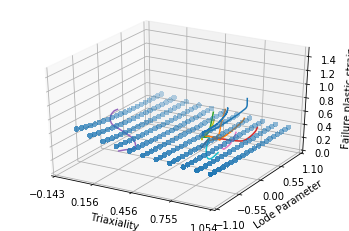

In [131]:
a, b , c, d = resUsingFractureStrain.x[:]
failureSurface = MMCSurface(a, b, c,d)
showFigure(failureSurface, tests)

In [108]:
def writeTable(failueSurface):
    etaX, thetaY, strain = failueSurface
    #print (etaX, thetaY)
    eta = etaX[0, :]
    theta = thetaY[:, 0]
    print(eta.shape, strain.shape)
    with open ('mmc.tab','w+') as f:
        
        f.write('*DEFINE_TABLE\n')
        f.write('#$Lode Parameter vs. load curves'+'\n')
        f.write('$'+'{:>9}'.format('TBID')+'\n')
        f.write(' '+'{:>9d}'.format(theta.shape[0]+1)+'\n')
        f.write('$'+'{:>9}'.format(' ')+
            '{:>10}'.format('VALUE')+
            '{:>10}'.format('LCID')+'\n')
        
        for ii, ll in enumerate(theta):
            #print(ii)
            f.write('{:>10}'.format(' ')+
                '{:>10.3f}'.format(ll)+
                '{:10d}'.format(ii+1)+'\n')
        f.write('$'+'\n')
        
        for ii, _ in enumerate(theta):
            f.write('*DEFINE_CURVE'+'\n')
            f.write('#$Triaxiality vs. Failure Plastic Strain'+'\n')
            f.write('$'+'{:>9}'.format('LCID')+
                '{:>10}'.format('SIDR') + 
                '{:>10}'.format('SCLA') + 
                '{:>10}'.format('SCLO') + 
                '{:>10}'.format('OFFA') +
                '{:>10}'.format('OFFO') +
                '{:>10}'.format('DATTYP') +
                '{:>10}'.format(' ')+'\n')

            f.write('{:>10d}'.format(ii+1)+
                '{:>10d}'.format(0) + 
                '{:>10.2f}'.format(1.0) + 
                '{:>10.2f}'.format(1.0) + 
                '{:>10.2f}'.format(0.0) +
                '{:>10.2f}'.format(0.0) +
                '{:>10d}'.format(0) +
                '{:>10d}'.format(0) + '\n')

            f.write('$'+'{:>9}'.format(' ')+
                '{:>10}'.format('A1')+
                '{:>10}'.format(' ')+
                '{:>10}'.format('O1')+'\n')
            for jj, tt in enumerate(eta):
                f.write('{:>10}'.format(' ')+
                    '{:>10.3f}'.format(tt) + 
                    '{:>10}'.format(' ') +
                    '{:>10.2e}'.format(strain[ii,jj])+'\n')

In [110]:
writeTable(failureSurface)

(11,) (21, 11)
